<a href="https://colab.research.google.com/github/sumittagadiya/Salt_identification/blob/main/salt_identification_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
import joblib 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.python.data.experimental import AUTOTUNE
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize


In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation,ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D,MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [ ]:
os.chdir('/content/drive/MyDrive/SALT_Challange')
os.makedirs('TRAIN/',exist_ok=True)
os.makedirs('TEST/',exist_ok=True)
os.makedirs('FLAMINGO/',exist_ok=True)
os.makedirs('COMPETITION_DATA/',exist_ok=True)

In [ ]:
!ls

COMPETITION_DATA      FLAMINGO	    sample_submission.csv  train.csv
competition_data.zip  flamingo.zip  TEST		   train_valid_df.pkl
decoded_images.pkl    model_save    test.zip		   train.zip
depths.csv	      new.ipynb     TRAIN		   Untitled1.ipynb


In [ ]:
len(os.listdir('TRAIN/images'))

4000

In [ ]:
print('Number of train images',len(os.listdir('TRAIN/images')))
print('Number of test images',len(os.listdir('TEST/images')))

Number of train images 4000
Number of test images 18000


In [ ]:
# get image ids
train_image_ids = sorted(os.listdir('TRAIN/images'))
train_mask_ids = sorted(os.listdir('TRAIN/masks'))
# print sample
print('Examle of image ids ==> ',train_image_ids[:2])
print('Examle of image masks ==> ',train_mask_ids[:2])

Examle of image ids ==>  ['000e218f21.png', '008a50a2ec.png']
Examle of image masks ==>  ['010ee525b6.png', '016fc8031c.png']


In [ ]:
X = np.zeros((len(train_image_ids), 128, 128, 1), dtype=np.float32)
y = np.zeros((len(train_image_ids), 128, 128, 1), dtype=np.float32)

In [ ]:
for ind, img_id in tqdm(enumerate(train_image_ids)):
    # Load images
    img = load_img("TRAIN/images/"+img_id, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = load_img("TRAIN/masks/"+img_id, grayscale=True)
    mask = img_to_array(mask)
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[ind] = x_img/255.0
    y[ind] = mask/255.0


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [ ]:
X.shape

(4000, 128, 128, 1)

In [ ]:
y.shape

(4000, 128, 128, 1)

In [ ]:
joblib.dump((X,y),'decoded_images.pkl')

['decoded_images.pkl']

In [ ]:
X,y = joblib.load('decoded_images.pkl')

In [ ]:
y = y.astype(bool)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
print('X_train Shape ',X_train.shape)
print('X_valid Shape', X_valid.shape)

X_train Shape  (3600, 128, 128, 1)
X_valid Shape (400, 128, 128, 1)


Text(0.5, 1.0, 'Salt')

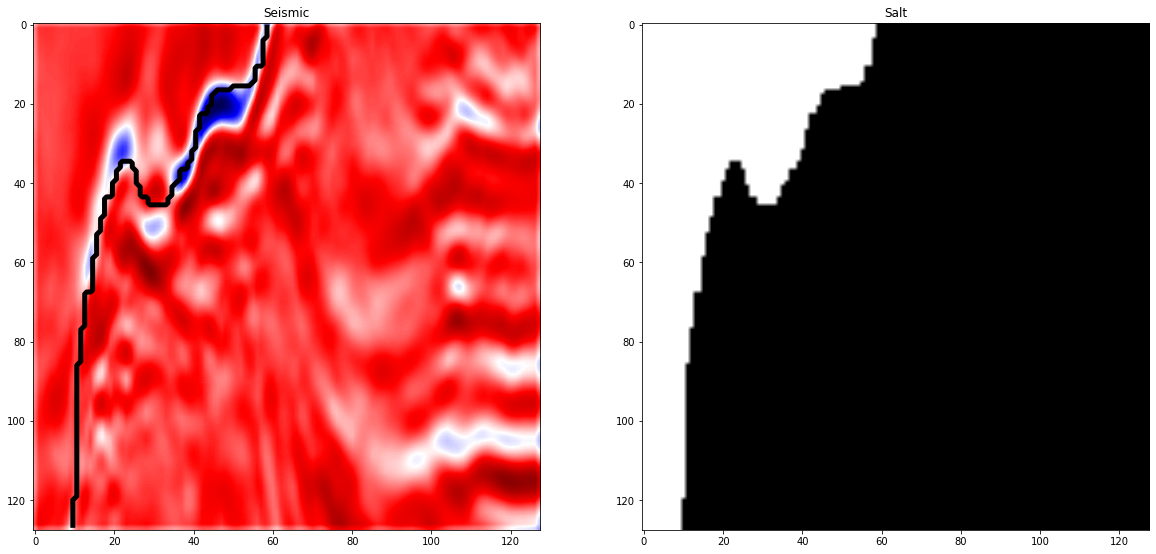

In [ ]:
# Visualize any randome image along with the mask
ix = np.random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x


In [ ]:
def unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = False):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
from keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [ ]:

# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard

###############
# BINARY LOSSES
###############
def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss, strict=True, name="loss")
    return loss
def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    logits = y_pred
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

def symmetric_lovasz(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    loss = ((lovasz_hinge(y_pred, y_true, per_image = True, ignore = None)) + \
            (lovasz_hinge(-y_pred, 1 - y_true, per_image = True, ignore = None))) /2
    return loss


In [ ]:
input_img = Input((128, 128, 1), name='in_img')
model = unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.binary_crossentropy, metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in_img (InputLayer)             [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 160         in_img[0][0]                     
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 128, 128, 16) 64          conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 128, 128, 16) 0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

In [ ]:
#!rm -rf 'model_save'
#del model

In [ ]:
os.makedirs('model_save/',exist_ok=True)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('model_save/best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=30, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
225/225 [==============================] - 17s 71ms/step - loss: 0.4145 - mean_io_u_1: 0.3728 - val_loss: 1.8061 - val_mean_io_u_1: 0.3814

Epoch 00001: val_loss improved from inf to 1.80612, saving model to model_save/best_model.h5
Epoch 2/30
225/225 [==============================] - 16s 69ms/step - loss: 0.2796 - mean_io_u_1: 0.3740 - val_loss: 0.3997 - val_mean_io_u_1: 0.3814

Epoch 00002: val_loss improved from 1.80612 to 0.39965, saving model to model_save/best_model.h5
Epoch 3/30
225/225 [==============================] - 15s 68ms/step - loss: 0.2512 - mean_io_u_1: 0.3724 - val_loss: 0.3422 - val_mean_io_u_1: 0.3814

Epoch 00003: val_loss improved from 0.39965 to 0.34221, saving model to model_save/best_model.h5
Epoch 4/30
225/225 [==============================] - 15s 68ms/step - loss: 0.2246 - mean_io_u_1: 0.3747 - val_loss: 0.3430 - val_mean_io_u_1: 0.3814

Epoch 00004: val_loss did not improve from 0.34221
Epoch 5/30
225/225 [==============================] - 15s 

In [ ]:
model_json = model.to_json()
with open('model_save/unet_model.json','w') as json_file:
    json_file.write(model_json)
print('Model saved to disk in json format')

Model saved to disk in json format


In [ ]:
model.load_weights('model_save/best_model.h5')

In [ ]:
model.evaluate(X_valid, y_valid, verbose=1)

13/13 [==============================] - 13s 508ms/step - loss: 0.1291 - mean_io_u: 0.3838


[0.1446862369775772, 0.3814437985420227]

In [ ]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

13/13 [==============================] - 0s 38ms/step


In [ ]:
preds_train_th = (preds_train > 0.5).astype(np.uint8)
preds_val_th = (preds_val > 0.5).astype(np.uint8)

In [ ]:
def plot_sample(X, y, prediction, binary_prediction, index=None):
    """Function to plot the results"""
    if index is None:
        index = random.randint(0, len(X))

    has_mask = y[index].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    # plot origiba seismic image
    ax[0].imshow(X[index, ..., 0], cmap='seismic')
    # if mask
    if has_mask:
        # draw seperation line
        ax[0].contour(y[index].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    # plot original mask image
    ax[1].imshow(y[index].squeeze())
    ax[1].set_title('Salt')
    
    # plot predicted image
    ax[2].imshow(prediction[index].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[index].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    # plot binary predicted image
    ax[3].imshow(binary_prediction[index].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[index].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

# prediction on train data

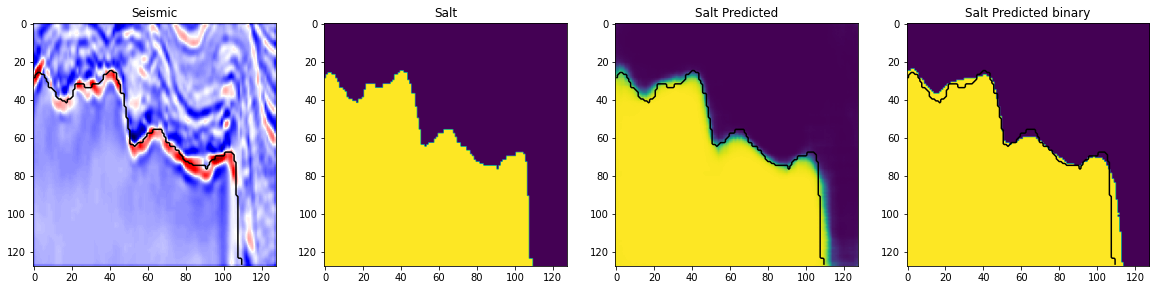

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_th, index=50)


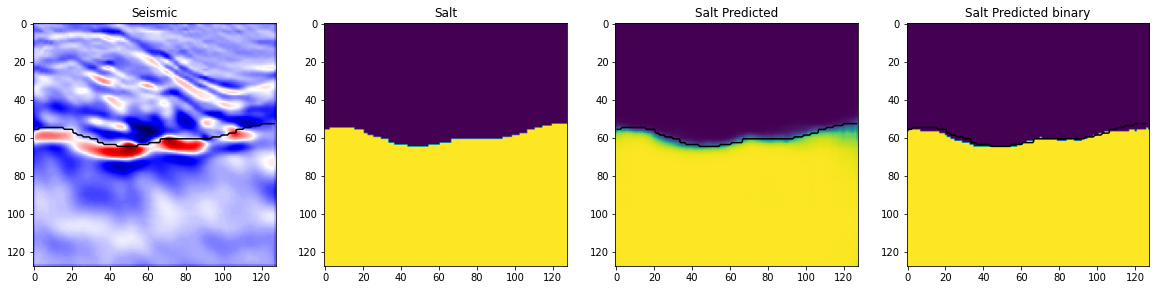

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_th, index=5)

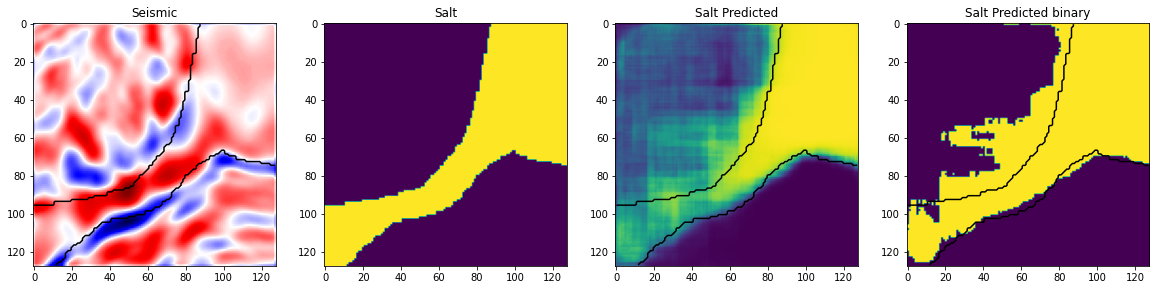

In [ ]:
plot_sample(X_train, y_train, preds_train1, preds_train_th1, index=10)


# Train different Model

In [ ]:
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_function(get_iou_vector, [label, float(pred > 0.5)], tf.float64)

In [ ]:
# Build U-Net model
inputs = Input((128, 128, 1))

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=[tf.keras.metrics.Accuracy(name='accuracy'),
                       my_iou_metric])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 8)  80          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 8)  584         conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 8)    0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [ ]:
os.makedirs('model_save_3/',exist_ok=True)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('model_save_3/best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
Y = y.astype(float)

Y_train = y_train.astype(float)
Y_valid = y_valid.astype(float)

In [ ]:
X1 = np.append(X, [np.fliplr(x) for x in X], axis=0)
Y1 = np.append(Y, [np.fliplr(x) for x in Y], axis=0)

In [ ]:
X1.shape

(8000, 128, 128, 1)

In [ ]:
history = model.fit(X1, Y1, batch_size=16, validation_split=0.1,
                    epochs=50, callbacks=callbacks,shuffle=True)

Epoch 1/50
450/450 [==============================] - 17s 34ms/step - loss: 0.5472 - accuracy: 0.0000e+00 - my_iou_metric: 0.3785 - val_loss: 0.3901 - val_accuracy: 0.0000e+00 - val_my_iou_metric: 0.5000

Epoch 00001: val_loss improved from inf to 0.39006, saving model to model_save_3/best_model.h5
Epoch 2/50
450/450 [==============================] - 15s 33ms/step - loss: 0.3836 - accuracy: 1.0276e-04 - my_iou_metric: 0.5150 - val_loss: 0.3074 - val_accuracy: 5.6259e-04 - val_my_iou_metric: 0.5502

Epoch 00002: val_loss improved from 0.39006 to 0.30738, saving model to model_save_3/best_model.h5
Epoch 3/50
450/450 [==============================] - 15s 33ms/step - loss: 0.3082 - accuracy: 0.0016 - my_iou_metric: 0.5640 - val_loss: 0.2392 - val_accuracy: 0.0048 - val_my_iou_metric: 0.6469

Epoch 00003: val_loss improved from 0.30738 to 0.23916, saving model to model_save_3/best_model.h5
Epoch 4/50
450/450 [==============================] - 15s 33ms/step - loss: 0.2698 - accuracy: 0.003

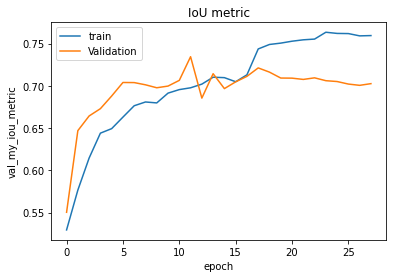

In [ ]:
plt.plot(history.history['my_iou_metric'][1:])
plt.plot(history.history['val_my_iou_metric'][1:])
plt.title('IoU metric')
plt.ylabel('val_my_iou_metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

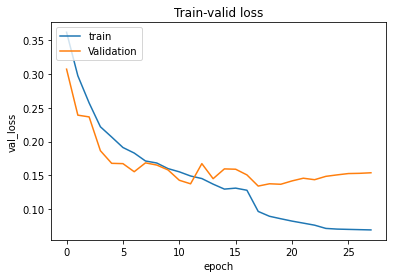

In [ ]:
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Train-valid loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(X_valid, y_valid, verbose=1)

13/13 [==============================] - 1s 35ms/step - loss: 0.0706 - accuracy: 0.0975 - my_iou_metric: 0.7942


[0.0705859437584877, 0.0974632278084755, 0.7942308187484741]

In [ ]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

13/13 [==============================] - 0s 10ms/step


In [ ]:
preds_train_th = (preds_train > 0.5).astype(np.uint8)
preds_val_th = (preds_val > 0.5).astype(np.uint8)

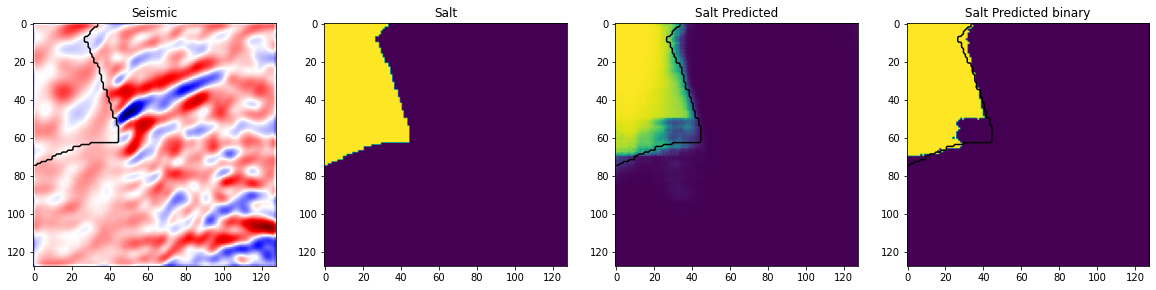

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_th, index=500)

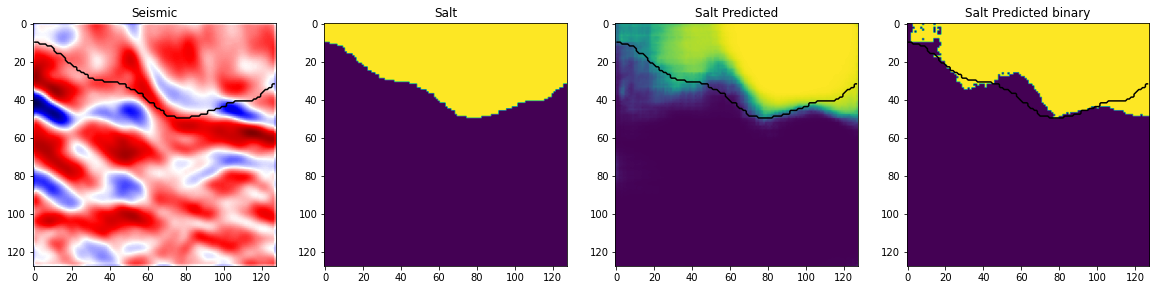

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_th, index=7)

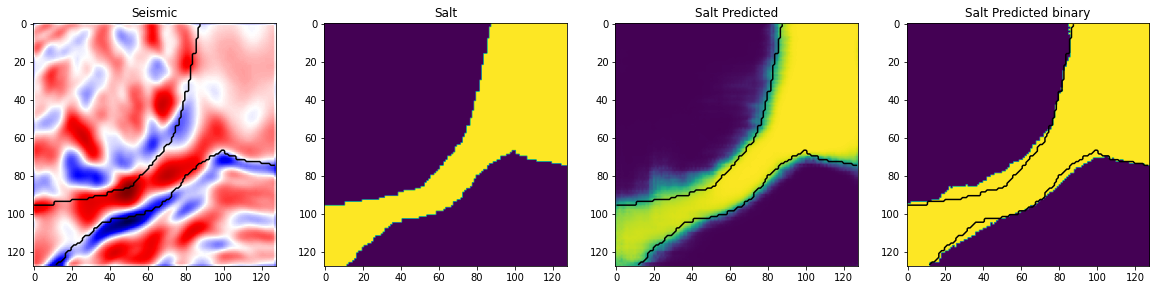

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_th, index=10)

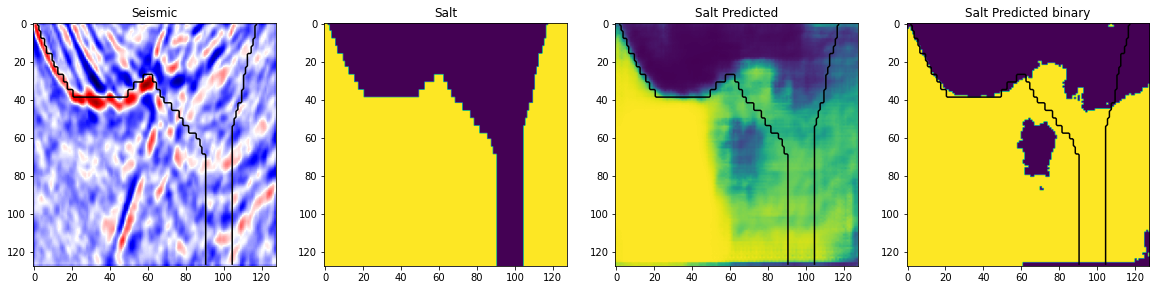

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_th, index=11)

# Helper functions

In [ ]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

def predict_result(model,x_test,batch_size): 
    '''This function will predict average of x_valid data and reflect of x_valid data''' 
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test1 = model.predict([x_test],batch_size=batch_size,verbose=1)
    preds_test2_refect = model.predict([x_test_reflect],batch_size=batch_size,verbose=1)
    preds_test2 = np.array([ np.fliplr(x) for x in preds_test2_refect] )
    preds_avg = (preds_test1 +preds_test2)/2
    return preds_avg

In [ ]:
model.load_weights('model_save_3/best_model.h5')

In [ ]:
predict_valid = predict_result(model,X_valid,16)

In [ ]:
predict_valid.shape

(400, 128, 128, 1)

In [ ]:
y_valid.shape

(400, 128, 128, 1)

# Find best threshold to get better IOU 

In [ ]:
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(y_valid, np.int32(predict_valid > threshold)) for threshold in tqdm(thresholds)])

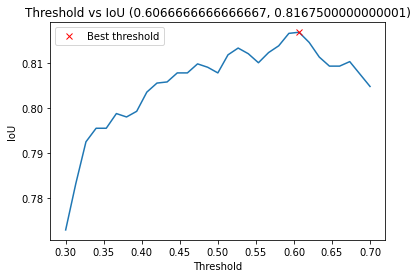

In [ ]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

As we can 0.6 is best threshold value which we wilol use on test data evaluation

# Test Prediction

In [ ]:
test_ids = sorted(os.listdir('TEST/images'))
len(test_ids)

18000

In [ ]:
# Get and resize test images
def test_image_array(test_ids):
    ''' This  function will return resized array of test images'''
    X_test = np.zeros((len(test_ids), 128, 128, 1), dtype=np.float32)
    sizes_test = []
    for n, id in tqdm(enumerate(test_ids)):
        img = load_img('TEST/images/' + id,color_mode='grayscale')
        x = img_to_array(img)
        sizes_test.append([x.shape[0], x.shape[1]])
        x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
        X_test[n] = x/255
    return sizes_test,X_test

### As we know there are 18000 test images so it will take long time so we will run this process in chunks so if colab crashes then we would have saved arrays in disk

In [ ]:
test_ids1 = test_ids[:2000]
test_img_size1, x_test1 = test_image_array(test_ids1)

In [ ]:
os.makedirs('test_arrays/',exist_ok=True)
joblib.dump((test_img_size1,x_test1),'test_arrays/test_chunk1.pkl')

['test_arrays/test_chunk1.pkl']

In [ ]:
test_ids2 = test_ids[2000:4000]
test_img_size2, x_test2 = test_image_array(test_ids2)

joblib.dump((test_img_size2,x_test2),'test_arrays/test_chunk2.pkl')

['test_arrays/test_chunk2.pkl']

In [ ]:
test_ids3 = test_ids[4000:6000]
test_img_size3, x_test3 = test_image_array(test_ids3)

joblib.dump((test_img_size3,x_test3),'test_arrays/test_chunk3.pkl')

['test_arrays/test_chunk3.pkl']

In [ ]:
test_ids4 = test_ids[6000:8000]
test_img_size4, x_test4 = test_image_array(test_ids4)

joblib.dump((test_img_size4,x_test4),'test_arrays/test_chunk4.pkl')

['test_arrays/test_chunk4.pkl']

In [ ]:
test_ids5 = test_ids[8000:10000]
test_img_size5, x_test5 = test_image_array(test_ids5)

joblib.dump((test_img_size5,x_test5),'test_arrays/test_chunk5.pkl')

['test_arrays/test_chunk5.pkl']

In [ ]:
test_ids6 = test_ids[10000:]
test_img_size6, x_test6 = test_image_array(test_ids6)

joblib.dump((test_img_size6,x_test6),'test_arrays/test_chunk6.pkl')

['test_arrays/test_chunk6.pkl']

In [ ]:
print('shape of test img arrays chunk ')
print(x_test1.shape)
print(x_test2.shape)
print(x_test3.shape)
print(x_test4.shape)
print(x_test5.shape)
print(x_test6.shape)

shape of test img arrays chunk 
(2000, 128, 128, 1)
(2000, 128, 128, 1)
(2000, 128, 128, 1)
(2000, 128, 128, 1)
(2000, 128, 128, 1)
(8000, 128, 128, 1)


# Combine all chunked test array 




In [ ]:
test_img_array = np.vstack((x_test1,x_test2,x_test3,x_test4,x_test5,x_test6))

In [ ]:
test_img_array.shape

(18000, 128, 128, 1)

In [ ]:
joblib.dump(test_img_array,'test_img_final_array.pkl')

['test_img_final_array.pkl']

In [ ]:
test_img_sizes = test_img_size1 + test_img_size2 + test_img_size3 + test_img_size4 +test_img_size5 + test_img_size6
joblib.dump(test_img_sizes,'test_img_final_size.pkl')

['test_img_final_size.pkl']

In [ ]:
print('Length of test image sizes ==> ',len(test_img_sizes))

Length of test image sizes ==>  18000


# Load back 

In [ ]:
test_img_array = joblib.load('test_img_final_array.pkl')
test_img_sizes = joblib.load('test_img_final_size.pkl')

In [ ]:
preds_test = model.predict(test_img_array, verbose=1)

563/563 [==============================] - 280s 497ms/step


In [ ]:
# we will use threshold value  0.6 because it is best valur we got
preds_test_th = (preds_test > 0.6).astype(np.uint8)

In [ ]:
predict_test = predict_result(model,test_img_array,batch_size=16)

1125/1125 [==============================] - 312s 277ms/step


In [ ]:
predict_test_th = (predict_test>0.6).astype(np.uint8)

# Visulize Test Images

In [ ]:
def plot_test(test, test_predict, test_predict_binary,index):
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    # plot origiba seismic image
    ax[0].set_title('Test image')
    ax[0].imshow(test[index].squeeze(), cmap='seismic')
    ax[1].set_title('Predicted')
    ax[1].imshow(test_predict[index].squeeze(),vmin=0, vmax=1,cmap='Greens_r')
    ax[2].set_title('Binary predicted')
    ax[2].imshow(test_predict_binary[index].squeeze(),vmin=0, vmax=1,cmap='Greens_r')

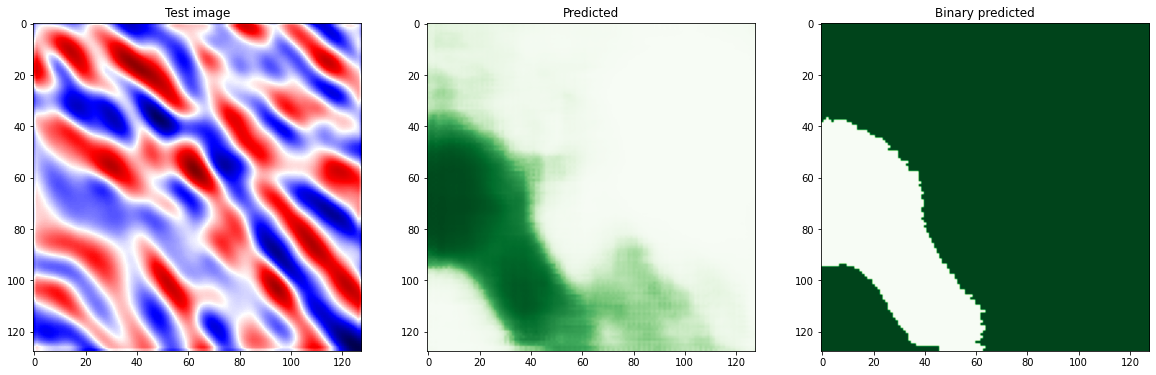

In [ ]:
plot_test(test_img_array,preds_test,preds_test_th,79)

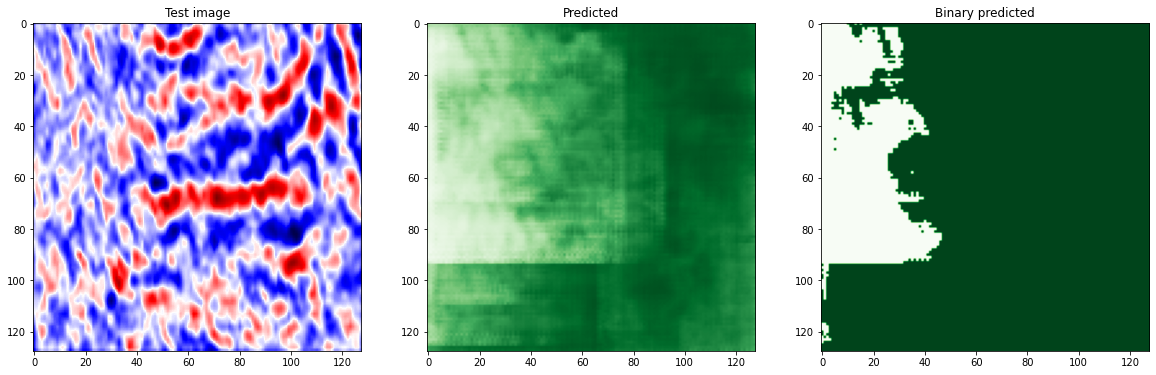

In [ ]:
plot_test(test_img_array,preds_test,preds_test_th,92)

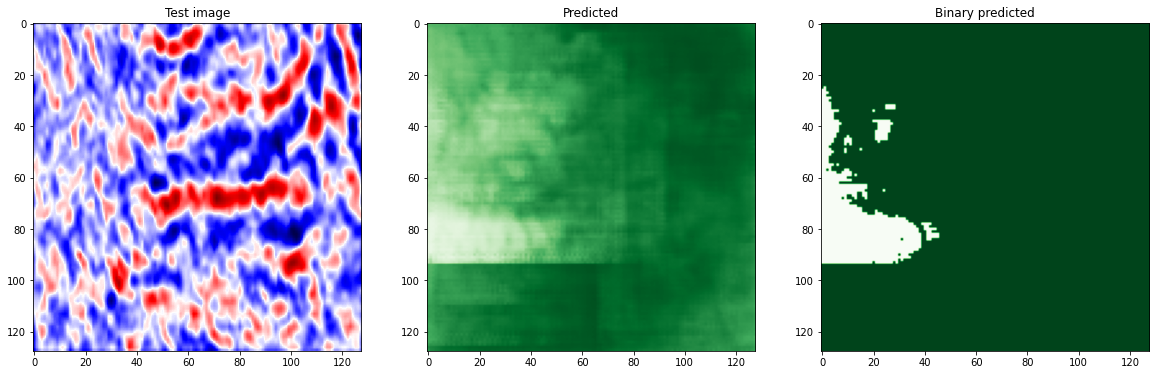

In [ ]:
plot_test(test_img_array,predict_test,predict_test_th,92)

# Downsample predicted test (original size)

In [ ]:
from tqdm import tnrange

In [ ]:
preds_test_resized = []
for i in tnrange(len(predict_test)):
    resized = resize(np.squeeze(predict_test[i]),(test_img_sizes[i][0],test_img_sizes[i][1]),
                     mode='constant',preserve_range=True)
    final = np.round(resized > 0.6)
    preds_test_resized.append(final)
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


In [ ]:
def RLE_Encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
# file[:-4] will give image id

predicted_dict = { img[:-4] : RLE_Encode(preds_test_resized[i]) \
                  for i,img in tqdm(enumerate(test_ids))}

# Submission 

In [ ]:
submission_df = pd.DataFrame.from_dict(predicted_dict,orient='index')
submission_df.index.names = ['id']
submission_df.columns = ['rle_mask']
submission_df.to_csv('submission.csv')

In [ ]:
submission_df.head()

,rle_mask
id,
0005bb9630,
000a68e46c,
000c8dfb2a,
000d0a5f6c,
001ef8fc87,1 7369 7374 86 7475 81 7576 72 7677 66 7778 60...


# Another submission

In [ ]:
pred_test_resized_main = []
for i in tnrange(len(preds_test)):
    resized = resize(np.squeeze(preds_test[i]),(test_img_sizes[i][0],test_img_sizes[i][1]),
                     mode='constant',preserve_range=True)
    final = np.round(resized > 0.6)
    pred_test_resized_main.append(final)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


In [ ]:
predicted_dict_main = { img[:-4] : RLE_Encode(pred_test_resized_main[i]) \
                  for i,img in tqdm(enumerate(test_ids))}

In [ ]:
submission_df1 = pd.DataFrame.from_dict(predicted_dict_main,orient='index')
submission_df1.index.names = ['id']
submission_df1.columns = ['rle_mask']
submission_df1.to_csv('submission1.csv')

In [ ]:
submission_df1.head()

,rle_mask
id,
0005bb9630,
000a68e46c,14 1 113 1 115 1
000c8dfb2a,
000d0a5f6c,
001ef8fc87,1 7461 7464 2 7467 2 7475 76 7552 3 7576 72 76...
